In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import pandas as pd
from pathlib import Path
import nibabel as nib
from brats.utils import dcm2nifti, show_mri

from shutil import copy

from brats.preprocessing.preprocessing import PreprocessorHDBET

In [6]:
df_tcga_t1 = pd.read_csv('/home/felipe-sassi/Data/T1_ONLY_BRATS.csv')
df_tcga_t2 = pd.read_csv('/home/felipe-sassi/Data/T2_ONLY_BRATS.csv')

In [197]:
df_tcga_t1 = pd.read_csv('/home/felipe-sassi/Data/DADOS_FALTANTES_T1.csv')
df_tcga_t2 = pd.read_csv('/home/felipe-sassi/Data/DADOS_FALTANTES.csv')

In [72]:
df_ivy_t1 = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_IVYGAP_T1_WITH_BRATS.csv')
df_ivy_t2 = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_IVYGAP_T2_WITH_BRATS.csv')

In [8]:
def dcm_bad_dir_to_nifti(dcm_dir, tmp_dcm_dir='.tmpdir/tmp_dcm'):
    tmp_dcm_dir = Path(tmp_dcm_dir)

    # clean tmp dir
    for f in tmp_dcm_dir.glob('*.dcm'):
        f.unlink()

    for f in Path(dcm_dir).glob('*.dcm'):
        (tmp_dcm_dir/f.name).symlink_to(f)
        
    return dcm2nifti(tmp_dcm_dir, '.tmpdir')

In [57]:
t1_fpath

[PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/_tmpdir_AX_T2_FSE_19970608090647_10.nii.gz'),
 PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/_tmpdir_AX_T1_19970608090647_12b.nii.gz')]

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/_tmpdir_AX_T1_19970608090647_12d.nii.gz (256, 256, 25)>

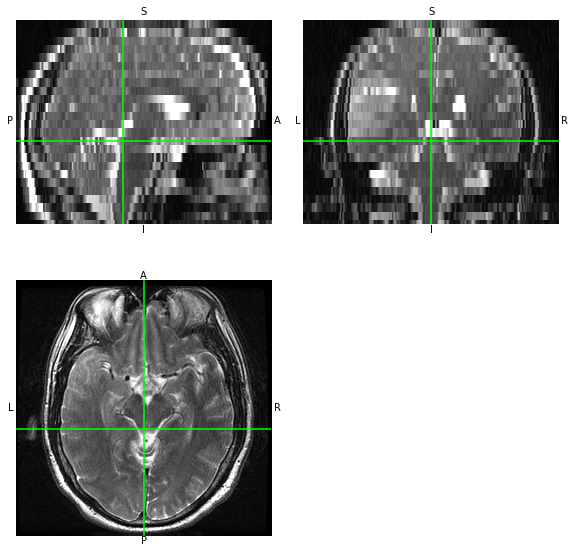

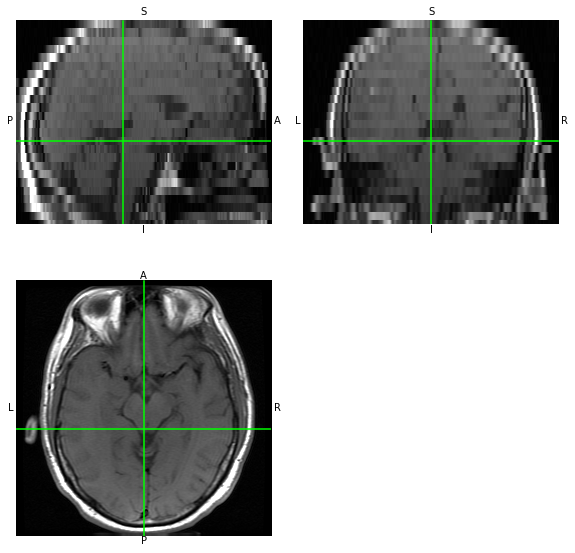

In [61]:
nib.load(t2_fpath[0]).orthoview()
nib.load(t2_fpath[1]).orthoview()

In [84]:

t1_dcm_dir = '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WWO CONTRAMR-81239/12.000000-AX T1-90444'
t1_fpath = dcm_bad_dir_to_nifti(t1_dcm_dir, '.tmpdir')

t2_dcm_dir = '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WWO CONTRAMR-81239/10.000000-AX T2 FSE-23822'
t2_fpath = dcm_bad_dir_to_nifti(t2_dcm_dir, '.tmpdir')[0]

nib.load(t1_fpath).orthoview()
nib.load(t2_fpath).orthoview()

220516-15:18:04,738 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.738426:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220516-15:18:04,739 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.738426:Found 50 DICOM file(s)
220516-15:18:04,739 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.738426:25 images have identical time, series, acquisition and instance values. DUPLICATES REMOVED.
220516-15:18:04,740 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.738426:Convert 25 DICOM as .tmpdir/_tmpdir_AX_T1_19970608090647_12g (256x256x25x1)
220516-15:18:04,791 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.791894:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/_tmpdir_AX_T1_19970608090647_12g.nii"
220516-15:18:04,792 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.791894:Conversion required 0.070018 seconds (0.017082 for core code).
220516-15:18:04,909 nipype.interface INFO:
	 stdout 2022-05-16T15:18:04.909797:Chris Rorden's dcm2niiX ve

In [9]:
from tqdm.notebook import tqdm

In [143]:
target_dir

PosixPath('/data/slow/PrepIMGs')

In [ ]:
from subprocess import CalledProcessError

prep = PreprocessorHDBET(
    template_fpath='/home/bruno-pacheco/brats-generalization/data/external/SRI24_T1_brain.nii',
    tmpdir='.tmpdir',
    bet_modality='T1',
    mode='fast',
)

tmp_dcm_dir='.tmpdir/tmp_dcm'
Path(tmp_dcm_dir).mkdir(exist_ok=True)

target_dir = Path('/data/slow/PrepIMGs')
target_dir.mkdir(exist_ok=True)

sid_disaligned = list()
multiple_t1 = list()
multiple_t2 = list()

doesnt_exist_t1 = list()
doesnt_exist_t2 = list()

gen_error = list()
for t1_s, t2_s in tqdm(list(zip(df_tcga_t1.sort_values(by='Subject ID').iloc, df_tcga_t2.sort_values(by='Subject ID').iloc))):
    target_t1_fpath = target_dir/(t1_s['Subject ID'] + '_T1.nii')
    target_t2_fpath = target_dir/(t1_s['Subject ID'] + '_T2.nii')

#     if t1_s['Subject ID'] == 'TCGA-76-4925':
#         continue

    if target_t1_fpath.exists():
        target_t1_fpath.unlink()

    if target_t2_fpath.exists():
        target_t2_fpath.unlink()
#     if target_t1_fpath.exists() and target_t2_fpath.exists():
#         continue

    if t1_s['Subject ID'] != t2_s['Subject ID']:
        print(f"Problem at id {t1_s.name}")
        sid_disaligned.append(t1_s.name)
        continue

    if not Path(t1_s['File Location']).exists():
        doesnt_exist_t1.append(t1_s['File Location'])
        continue

    if not Path(t2_s['File Location']).exists():
        doesnt_exist_t2.append(t2_s['File Location'])
        continue

    t1_fpath = dcm_bad_dir_to_nifti(t1_s['File Location'])
    t2_fpath = dcm_bad_dir_to_nifti(t2_s['File Location'])

    if isinstance(t1_fpath, list):
        for i in range(len(t1_fpath)):
            t1_fpath_ = t1_fpath[i]

            try:
                r = prep.run(t1_fpath=t1_fpath_, t2_fpath=t2_fpath)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], str(target_t1_fpath).replace('T1', f'T1_{i}'))
            nib.save(r['t2'], target_t2_fpath)
        continue

    if isinstance(t2_fpath, list):
        for i in range(len(t2_fpath)):
            t2_fpath_ = t2_fpath[i]

            try:
                r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath_)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], target_t1_fpath)
            nib.save(r['t2'], str(target_t2_fpath).replace('T2', f'T2_{i}'))
        continue

    try:
        r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
    except CalledProcessError:
        gen_error.append(t1_s['Subject ID'])
        continue

    nib.save(r['t1'], target_t1_fpath)
    nib.save(r['t2'], target_t2_fpath)

220530-14:32:27,86 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:32:27,87 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:Found 23 DICOM file(s)
220530-14:32:27,87 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:32:27,87 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:32:27,88 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:32:27,88 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.086566:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:32:27,88 nipype.interface INFO

220530-14:32:27,198 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:32:27,199 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:32:27,199 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:32:27,199 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:32:27,200 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:32:27,200 nipype.interface INFO:
	 stdout 2022-05-30T14:32:27.189827:Warning: Unable to determine manufactur

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5d.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220530-14:32:42,902 nipype.interface INFO:
	 stdout 2022-05-30T14:32:42.902380:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:32:42,903 nipype.interface INFO:
	 stdout 2022-05-30T14:32:42.902380:Found 23 DICOM file(s)
220530-14:32:42,903 nipype.interface INFO:
	 stdout 2022-05-30T14:32:42.902380:DICOM appears corrupt: first group:elemen

220530-14:32:43,177 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-15.dcm'
220530-14:32:43,178 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-18.dcm'
220530-14:32:43,178 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-22.dcm'
220530-14:32:43,178 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:32:43,178 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:32:43,179 nipype.interface INFO:
	 stdout 2022-05-30T14:32:43.160679:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5e.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:32:59,599 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:32:59,603 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:Found 23 DICOM file(s)
220530-14:32:59,604 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:32:59,605 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:32:59,606 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:32:59,609 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.599624:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:32:59,610 nipype.interfa

220530-14:32:59,957 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:32:59,958 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:32:59,958 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:32:59,958 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:32:59,959 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:32:59,959 nipype.interface INFO:
	 stdout 2022-05-30T14:32:59.942497:Warning: Unable to determine manufactur

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5f.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:33:16,903 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:33:16,906 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:Found 23 DICOM file(s)
220530-14:33:16,907 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:33:16,908 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:33:16,909 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:33:16,910 nipype.interface INFO:
	 stdout 2022-05-30T14:33:16.903344:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:33:16,912 nipype.interfa

220530-14:33:17,344 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:33:17,344 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:33:17,344 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:33:17,344 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:33:17,345 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:33:17,345 nipype.interface INFO:
	 stdout 2022-05-30T14:33:17.332011:Warning: Unable to determine manufactur

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5g.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:33:40,386 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:33:40,386 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:Found 23 DICOM file(s)
220530-14:33:40,387 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:33:40,387 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:33:40,387 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:33:40,388 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.386123:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:33:40,388 nipype.interfa

220530-14:33:40,632 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:33:40,632 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:33:40,632 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:33:40,632 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:33:40,633 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:33:40,633 nipype.interface INFO:
	 stdout 2022-05-30T14:33:40.622803:Warning: Unable to determine manufactur

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5h.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220530-14:33:57,372 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.372591:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:33:57,375 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.372591:Found 23 DICOM file(s)
220530-14:33:57,376 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.372591:DICOM appears corrupt: first group:elemen

220530-14:33:57,581 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-15.dcm'
220530-14:33:57,581 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-18.dcm'
220530-14:33:57,581 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-22.dcm'
220530-14:33:57,583 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:33:57,583 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:33:57,583 nipype.interface INFO:
	 stdout 2022-05-30T14:33:57.576998:DICOM appears corrupt: first group:el

220530-14:33:57,942 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:M = [ ...
220530-14:33:57,942 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840: 0.0312034133822             -nan 
220530-14:33:57,942 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:               0             -nan  ]
220530-14:33:57,943 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:57,943 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:57,943 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:M = [ ...
220530-14:33:57,943 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840: 0.0312034133822             -nan 
220530-14:33:57,943 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.933840:              

220530-14:33:57,956 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:57,956 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:M = [ ...
220530-14:33:57,958 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345: 0.0312034133822             -nan 
220530-14:33:57,958 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:               0             -nan  ]
220530-14:33:57,958 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:57,958 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:57,959 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.950345:M = [ ...
220530-14:33:57,959 nipype.in

220530-14:33:57,970 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:57,970 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:57,971 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:M = [ ...
220530-14:33:57,971 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215: 0.0312034133822             -nan 
220530-14:33:57,971 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:               0             -nan  ]
220530-14:33:57,971 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:57,971 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.966215:/home/brun

220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198: 0.0312034133822             -nan 
220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198:               0             -nan  ]
220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198:M = [ ...
220530-14:33:57,985 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198: 0.0312034133822             -nan 
220530-14:33:57,986 nipype.interface INFO:
	 stderr 2022-05-30T14:33:57.982198:               0             -nan  ]
220530-14:33:57,986 nipype.interface INFO:
	 stderr 2022-05-30T14:

220530-14:33:58,385 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:M = [ ...
220530-14:33:58,385 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -nan             -nan 
220530-14:33:58,386 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -nan             -nan  ]
220530-14:33:58,386 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:58,386 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:58,387 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:M = [ ...
220530-14:33:58,387 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -nan             -nan 
220530-14:33:58,387 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -n

220530-14:33:58,400 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:58,400 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:M = [ ...
220530-14:33:58,400 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -nan             -nan 
220530-14:33:58,400 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.385197:            -nan             -nan  ]
220530-14:33:58,401 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:58,402 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:58,402 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:M = [ ...
220530-14:33:58,402 nipype.in

220530-14:33:58,412 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:58,412 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:58,412 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:M = [ ...
220530-14:33:58,412 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:            -nan             -nan 
220530-14:33:58,413 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:            -nan             -nan  ]
220530-14:33:58,413 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:58,413 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.401856:/home/brun

220530-14:33:58,426 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:            -nan             -nan 
220530-14:33:58,427 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:            -nan             -nan  ]
220530-14:33:58,427 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (2) from SVDC
220530-14:33:58,427 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:/home/bruno-pacheco/build/ITKv5/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 2x2
220530-14:33:58,427 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:M = [ ...
220530-14:33:58,427 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:            -nan             -nan 
220530-14:33:58,428 nipype.interface INFO:
	 stderr 2022-05-30T14:33:58.417941:            -nan             -nan  ]
220530-14:33:58,428 nipype.interface INFO:
	 stderr 2022-05-30T14:

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/data_loading.py:24: RuntimeWarning: invalid value encountered in true_divide
  image /= image.std()
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)
Traceback (most recent call last):
  File "/home/bruno-pacheco/anaconda3/envs/brats/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 119, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 107, in run_hd_bet
    s


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5i.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
220530-14:34:07,248 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.247706:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:34:07,250 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.247706:Found 124 DICOM file(s)
220530-14:34:07,250 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.247706:DICOM appears corrupt: first group:element should be 0x0002:0x0000

220530-14:34:07,282 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-73.dcm'
220530-14:34:07,282 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-20.dcm'
220530-14:34:07,282 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-86.dcm'
220530-14:34:07,282 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-92.dcm'
220530-14:34:07,283 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-65.dcm'
220530-14:34:07,283 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.281453:DICOM appears corrupt: first group:e

220530-14:34:07,366 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:34:07,368 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-46.dcm'
220530-14:34:07,369 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-32.dcm'
220530-14:34:07,370 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-122.dcm'
220530-14:34:07,371 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:34:07,371 nipype.interface INFO:
	 stdout 2022-05-30T14:34:07.356374:DICOM appears corrupt: first group:e

220530-14:34:08,50 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-101.dcm'
220530-14:34:08,50 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-85.dcm'
220530-14:34:08,50 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:34:08,51 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-48.dcm'
220530-14:34:08,51 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-75.dcm'
220530-14:34:08,51 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.044818:DICOM appears corrupt: first group:elemen

220530-14:34:08,152 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-66.dcm'
220530-14:34:08,153 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-87.dcm'
220530-14:34:08,154 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-98.dcm'
220530-14:34:08,154 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-30.dcm'
220530-14:34:08,154 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-40.dcm'
220530-14:34:08,154 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.139027:DICOM appears corrupt: first group:e

220530-14:34:08,242 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-109.dcm'
220530-14:34:08,242 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-120.dcm'
220530-14:34:08,243 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-76.dcm'
220530-14:34:08,243 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-112.dcm'
220530-14:34:08,243 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-97.dcm'
220530-14:34:08,243 nipype.interface INFO:
	 stdout 2022-05-30T14:34:08.225766:DICOM appears corrupt: first grou

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6d.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:34:29,430 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:34:29,433 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:Found 24 DICOM file(s)
220530-14:34:29,433 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:34:29,434 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:34:29,434 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:34:29,434 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.430219:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:34:29,435 nipype.interfa

220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-22.dcm'
220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:34:29,708 nipype.interface INFO:
	 stdout 2022-05-30T14:34:29.698252:DICOM appears corrupt: first group:elem

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5j.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:34:47,157 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:34:47,160 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:Found 124 DICOM file(s)
220530-14:34:47,161 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-61.dcm'
220530-14:34:47,163 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-79.dcm'
220530-14:34:47,164 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-111.dcm'
220530-14:34:47,165 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.156834:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-67.dcm'
220530-14:34:47,166 nipype.inte

220530-14:34:47,195 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-92.dcm'
220530-14:34:47,195 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-65.dcm'
220530-14:34:47,196 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-16.dcm'
220530-14:34:47,196 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-110.dcm'
220530-14:34:47,196 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-5.dcm'
220530-14:34:47,196 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.194427:DICOM appears corrupt: first group:e

220530-14:34:47,279 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-122.dcm'
220530-14:34:47,279 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:34:47,279 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-64.dcm'
220530-14:34:47,279 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-62.dcm'
220530-14:34:47,279 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-80.dcm'
220530-14:34:47,280 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.270660:DICOM appears corrupt: first group:

220530-14:34:47,585 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-5.dcm'
220530-14:34:47,585 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-1.dcm'
220530-14:34:47,585 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-7.dcm'
220530-14:34:47,585 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-13.dcm'
220530-14:34:47,585 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-15.dcm'
220530-14:34:47,586 nipype.interface INFO:
	 stdout 2022-05-30T14:34:47.577034:DICOM appears corrupt: first group:elem

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_14.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:35:09,95 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:35:09,97 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:Found 23 DICOM file(s)
220530-14:35:09,98 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:35:09,98 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:35:09,99 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:35:09,100 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.095585:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:35:09,100 nipype.interface IN

220530-14:35:09,416 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:35:09,417 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:35:09,417 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:35:09,417 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:35:09,417 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:35:09,418 nipype.interface INFO:
	 stdout 2022-05-30T14:35:09.400909:Warning: Unable to determine manufactur

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6e.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220530-14:35:23,888 nipype.interface INFO:
	 stdout 2022-05-30T14:35:23.888277:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:35:23,892 nipype.interface INFO:
	 stdout 2022-05-30T14:35:23.888277:Found 23 DICOM file(s)
220530-14:35:23,893 nipype.interface INFO:
	 stdout 2022-05-30T14:35:23.888277:DICOM appears corrupt: first group:elemen

220530-14:35:24,150 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-15.dcm'
220530-14:35:24,150 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-18.dcm'
220530-14:35:24,150 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-22.dcm'
220530-14:35:24,150 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:35:24,150 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:35:24,151 nipype.interface INFO:
	 stdout 2022-05-30T14:35:24.141061:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5k.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:35:41,57 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:35:41,58 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:Found 36 DICOM file(s)
220530-14:35:41,58 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:35:41,59 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:35:41,59 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-28.dcm'
220530-14:35:41,59 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.057687:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-36.dcm'
220530-14:35:41,59 nipype.interface INF

220530-14:35:41,628 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-48.dcm'
220530-14:35:41,628 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-44.dcm'
220530-14:35:41,628 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-38.dcm'
220530-14:35:41,629 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-52.dcm'
220530-14:35:41,629 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-69.dcm'
220530-14:35:41,629 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.623070:DICOM appears corrupt: first group:e

220530-14:35:41,661 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-60.dcm'
220530-14:35:41,661 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-39.dcm'
220530-14:35:41,661 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-25.dcm'
220530-14:35:41,661 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:35:41,662 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-46.dcm'
220530-14:35:41,662 nipype.interface INFO:
	 stdout 2022-05-30T14:35:41.657947:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6f.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6f.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:36:16,308 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:36:16,309 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:Found 36 DICOM file(s)
220530-14:36:16,310 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:36:16,311 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:36:16,312 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-28.dcm'
220530-14:36:16,312 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.307913:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-36.dcm'
220530-14:36:16,313 nipype.interf

220530-14:36:16,940 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:36:16,941 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-9.dcm'
220530-14:36:16,941 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-14.dcm'
220530-14:36:16,942 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-11.dcm'
220530-14:36:16,942 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-10.dcm'
220530-14:36:16,942 nipype.interface INFO:
	 stdout 2022-05-30T14:36:16.936264:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_8.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:36:44,151 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:36:44,152 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:Found 50 DICOM file(s)
220530-14:36:44,152 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-49.dcm'
220530-14:36:44,152 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:36:44,152 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:36:44,153 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.151269:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-48.dcm'
220530-14:36:44,153 nipype.interf

220530-14:36:44,164 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-29.dcm'
220530-14:36:44,164 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:36:44,164 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-3.dcm'
220530-14:36:44,164 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-19.dcm'
220530-14:36:44,165 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-34.dcm'
220530-14:36:44,165 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.163006:Warning: Unable to determine manufactu

220530-14:36:44,633 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.624920:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-20.dcm'
220530-14:36:44,633 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.624920:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-86.dcm'
220530-14:36:44,633 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.624920:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-92.dcm'
220530-14:36:44,925 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.925249:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-65.dcm'
220530-14:36:44,926 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.925249:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-16.dcm'
220530-14:36:44,928 nipype.interface INFO:
	 stdout 2022-05-30T14:36:44.925249:DICOM appears corrupt: first group:e

220530-14:36:45,101 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-76.dcm'
220530-14:36:45,102 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-97.dcm'
220530-14:36:45,103 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-35.dcm'
220530-14:36:45,103 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:36:45,104 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-84.dcm'
220530-14:36:45,105 nipype.interface INFO:
	 stdout 2022-05-30T14:36:45.098969:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6g.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_6g.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220530-14:37:15,981 nipype.interface INFO:
	 stdout 2022-05-30T14:37:15.981711:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:37:15,982 nipype.interface INFO:
	 stdout 2022-05-30T14:37:15.981711:Found 56 DICOM file(s)
220530-14:37:15,982 nipype.interface INFO:
	 stdout 2022-05-30T14:37:15.981711:DICOM appears corrupt: first group:elemen

220530-14:37:16,2 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:37:16,2 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-46.dcm'
220530-14:37:16,2 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-32.dcm'
220530-14:37:16,3 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:37:16,3 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-43.dcm'
220530-14:37:16,3 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.001951:DICOM appears corrupt: first group:element should

220530-14:37:16,634 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-81.dcm'
220530-14:37:16,634 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-11.dcm'
220530-14:37:16,635 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-45.dcm'
220530-14:37:16,635 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-72.dcm'
220530-14:37:16,635 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-10.dcm'
220530-14:37:16,635 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.623884:DICOM appears corrupt: first group:e

220530-14:37:16,659 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-96.dcm'
220530-14:37:16,659 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-56.dcm'
220530-14:37:16,659 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-71.dcm'
220530-14:37:16,660 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-22.dcm'
220530-14:37:16,660 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-42.dcm'
220530-14:37:16,660 nipype.interface INFO:
	 stdout 2022-05-30T14:37:16.649676:DICOM appears corrupt: first group:e

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_9.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_9.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:37:55,876 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:37:55,877 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:Found 54 DICOM file(s)
220530-14:37:55,878 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-49.dcm'
220530-14:37:55,878 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:37:55,879 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:37:55,880 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.876111:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-48.dcm'
220530-14:37:55,880 nipype.interf

220530-14:37:55,894 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-35.dcm'
220530-14:37:55,894 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-4.dcm'
220530-14:37:55,894 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-53.dcm'
220530-14:37:55,894 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-29.dcm'
220530-14:37:55,895 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-2.dcm'
220530-14:37:55,895 nipype.interface INFO:
	 stdout 2022-05-30T14:37:55.892929:DICOM appears corrupt: first group:ele

220530-14:37:56,437 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-6.dcm'
220530-14:37:56,437 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-37.dcm'
220530-14:37:56,437 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-23.dcm'
220530-14:37:56,437 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-26.dcm'
220530-14:37:56,438 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-63.dcm'
220530-14:37:56,438 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.422860:DICOM appears corrupt: first group:el

220530-14:37:56,569 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.529956:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-25.dcm'
220530-14:37:56,569 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.529956:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-8.dcm'
220530-14:37:56,574 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.574416:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-46.dcm'
220530-14:37:56,574 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.574416:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-32.dcm'
220530-14:37:56,575 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.574416:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-12.dcm'
220530-14:37:56,575 nipype.interface INFO:
	 stdout 2022-05-30T14:37:56.574416:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_8a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_8a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


220530-14:38:36,41 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:38:36,42 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:Found 34 DICOM file(s)
220530-14:38:36,43 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:38:36,44 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:38:36,44 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-28.dcm'
220530-14:38:36,45 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.040984:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-17.dcm'
220530-14:38:36,45 nipype.interface INF

220530-14:38:36,658 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-10.dcm'
220530-14:38:36,658 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-6.dcm'
220530-14:38:36,659 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-23.dcm'
220530-14:38:36,660 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-26.dcm'
220530-14:38:36,660 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-20.dcm'
220530-14:38:36,660 nipype.interface INFO:
	 stdout 2022-05-30T14:38:36.652359:DICOM appears corrupt: first group:el

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_8b.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220530-14:39:04,505 nipype.interface INFO:
	 stdout 2022-05-30T14:39:04.505507:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:39:04,507 nipype.interface INFO:
	 stdout 2022-05-30T14:39:04.505507:Found 38 DICOM file(s)
220530-14:39:04,507 nipype.interface INFO:
	 stdout 2022-05-30T14:39:04.505507:DICOM appears corrupt: first group:elemen

220530-14:39:05,173 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220530-14:39:05,175 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:Found 38 DICOM file(s)
220530-14:39:05,175 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-33.dcm'
220530-14:39:05,176 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-21.dcm'
220530-14:39:05,177 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-38.dcm'
220530-14:39:05,177 nipype.interface INFO:
	 stdout 2022-05-30T14:39:05.173299:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '.tmpdir/tmp_dcm/Image-28.dcm'
220530-14:39:05,178 nipype.interf

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.


In [194]:
t1_s

Unnamed: 0                                                          151
Subject ID                                                 TCGA-76-4925
Series Description                               BRAINPITUITARYPDT2AXIA
File Location         /data/slow/manifest-7AMtkRMr102480274090417257...
SET                                                         NOT ONLY T1
Name: 151, dtype: object

In [233]:
sid_disaligned

[]

In [234]:
multiple_t1, multiple_t2

([], [])

In [235]:
doesnt_exist_t1, doesnt_exist_t2

([], [])

In [236]:
gen_error

['TCGA-02-0047']

In [223]:
df_tcga_t1.sort_values(by='Subject ID').reset_index().iloc[20]

index                                                                 7
Subject ID                                                           W2
Series Description                                   AX T1 FSPGR 3D PRE
File Location         /data/slow/manifest-vKOJztmv485477422839823864...
SET                                                         NOT ONLY T1
Unnamed: 0                                                          NaN
Name: 20, dtype: object

In [224]:
df_tcga_t2.sort_values(by='Subject ID').reset_index().iloc[20]

index                                                                 6
Subject ID                                                           W2
Series Description                                    AX T2 FRFSEXL 2MM
File Location         /data/slow/manifest-vKOJztmv485477422839823864...
SET                                                             ONLY T2
Unnamed: 0                                                          NaN
Name: 20, dtype: object

In [225]:
t1_s = df_tcga_t1.sort_values(by='Subject ID').iloc[20]
t2_s = df_tcga_t2.sort_values(by='Subject ID').iloc[20]

t1_s, t2_s

(Subject ID                                                           W2
 Series Description                                   AX T1 FSPGR 3D PRE
 File Location         /data/slow/manifest-vKOJztmv485477422839823864...
 SET                                                         NOT ONLY T1
 Unnamed: 0                                                          NaN
 Name: 7, dtype: object,
 Subject ID                                                           W2
 Series Description                                    AX T2 FRFSEXL 2MM
 File Location         /data/slow/manifest-vKOJztmv485477422839823864...
 SET                                                             ONLY T2
 Unnamed: 0                                                          NaN
 Name: 6, dtype: object)

In [226]:
t1_fpath = dcm_bad_dir_to_nifti(t1_s['File Location'])
t2_fpath = dcm_bad_dir_to_nifti(t2_s['File Location'])

220525-14:12:27,78 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220525-14:12:27,79 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Found 136 DICOM file(s)
220525-14:12:27,79 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Convert 136 DICOM as .tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a (256x256x136x1)
220525-14:12:27,218 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.218154:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii"
220525-14:12:27,218 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.218154:Conversion required 0.190438 seconds (0.077352 for core code).
220525-14:12:27,410 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.410834:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220525-14:12:27,411 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.410834:Found 85 DICOM f

In [228]:
t2_fpath

PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T2_FRFSEXL_2MM_19961101102013_10a.nii.gz')

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii.gz (256, 256, 136)>

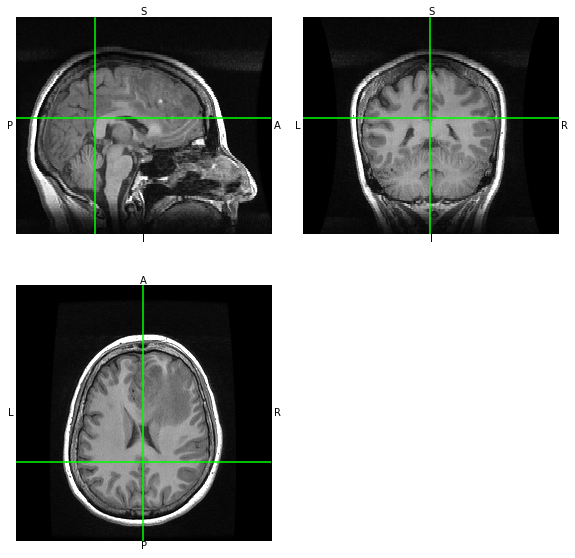

In [229]:
nib.load(t1_fpath).orthoview()

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T2_FRFSEXL_2MM_19961101102013_10a.nii.gz (256, 256, 85)>

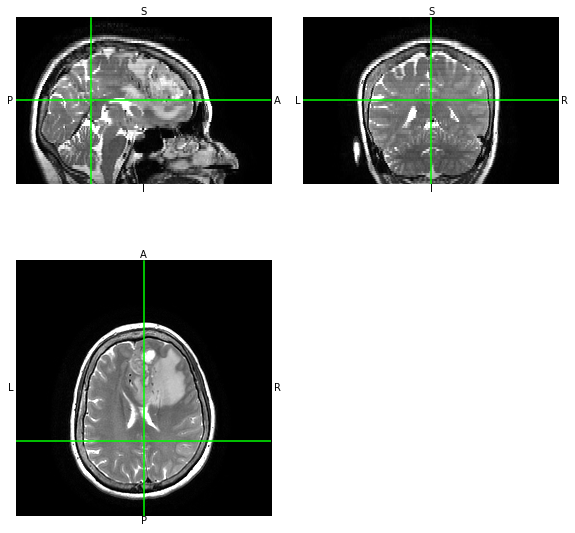

In [230]:
nib.load(t2_fpath).orthoview()

In [231]:
r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
r

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################



Traceback (most recent call last):
  File "/home/bruno-pacheco/anaconda3/envs/brats/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 119, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 463, in cuda
    return self._apply(lambda t: t.cuda(device))
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 359, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 381, in _apply
    param_applied = fn(param)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/

CalledProcessError: Command 'hd-bet -i /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii.gz -o .tmpdir/t1_template_tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a_mask -mode fast -device 0' returned non-zero exit status 1.

In [173]:
df_tcga_t1_fix = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_TCGA_T1_WITH_BRATS_CORRECTED.csv')
df_tcga_t2_fix = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_TCGA_T2_WITH_BRATS_CORRECTED.csv')

In [186]:
from subprocess import CalledProcessError

prep = PreprocessorHDBET(
    template_fpath='/home/bruno-pacheco/brats-generalization/data/external/SRI24_T1_brain.nii',
    tmpdir='.tmpdir',
    bet_modality='T1',
    mode='fast',
)

tmp_dcm_dir='.tmpdir/tmp_dcm'
Path(tmp_dcm_dir).mkdir(exist_ok=True)

target_dir = Path('/data/slow/PrepIMGs')
target_dir.mkdir(exist_ok=True)

sid_disaligned = list()
multiple_t1 = list()
multiple_t2 = list()

doesnt_exist_t1 = list()
doesnt_exist_t2 = list()

gen_error = list()
for t1_s, t2_s in tqdm(list(zip(df_tcga_t1_fix.sort_values(by='Subject ID').iloc, df_tcga_t2_fix.sort_values(by='Subject ID').iloc))):
    target_t1_fpath = target_dir/(t1_s['Subject ID'] + '_T1.nii')
    target_t2_fpath = target_dir/(t1_s['Subject ID'] + '_T2.nii')
    
    if target_t1_fpath.exists() and target_t2_fpath.exists():
        continue

    if t1_s['Subject ID'] != t2_s['Subject ID']:
        print(f"Problem at id {t1_s.name}")
        sid_disaligned.append(t1_s.name)
        continue
    
    if not Path(t1_s['File Location']).exists():
        doesnt_exist_t1.append(t1_s['File Location'])
        continue

    if not Path(t2_s['File Location']).exists():
        doesnt_exist_t2.append(t2_s['File Location'])
        continue

    t1_fpath = dcm_bad_dir_to_nifti(t1_s['File Location'])
    t2_fpath = dcm_bad_dir_to_nifti(t2_s['File Location'])

    if isinstance(t1_fpath, list):
        for i in range(len(t1_fpath)):
            t1_fpath_ = t1_fpath[i]
            
            try:
                r = prep.run(t1_fpath=t1_fpath_, t2_fpath=t2_fpath)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], str(target_t1_fpath).replace('T1', f'T1_{i}'))
            nib.save(r['t2'], target_t2_fpath)
        continue

    if isinstance(t2_fpath, list):
        for i in range(len(t2_fpath)):
            t2_fpath_ = t2_fpath[i]
            
            try:
                r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath_)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], target_t1_fpath)
            nib.save(r['t2'], str(target_t2_fpath).replace('T2', f'T2_{i}'))
        continue

    try:
        r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
    except CalledProcessError:
        gen_error.append(t1_s['Subject ID'])
        continue

    nib.save(r['t1'], target_t1_fpath)
    nib.save(r['t2'], target_t2_fpath)

220518-14:39:04,660 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:39:04,661 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Found 36 DICOM file(s)
220518-14:39:04,662 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.
220518-14:39:04,662 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Convert 36 DICOM as .tmpdir/tmp_dcm_TVP_Surgical_6_20080111000000_7a (256x256x36x1)
220518-14:39:04,725 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.725322:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii"
220518-14:39:04,725 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.725322:Conversion required 0.382404 seconds (0.034097 for core code).
220518-14:39:05,263 nipype.interface INFO:
	 stdout 2022-05-18T14:39:05.263570:Chris Ro

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:39:46,582 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:39:46,586 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Found 20 DICOM file(s)
220518-14:39:46,587 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Warning: Siemens 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19970316215726_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19970316215726_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:40:20,218 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:40:20,222 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Found 20 DICOM file(s)
220518-14:40:20,224 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Warning: 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19980824120926_4a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19980824120926_4a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:40:54,406 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:40:54,407 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Found 20 DICOM file(s)
220518-14:40:54,407 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Warning: 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_20010208144732_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_20010208144732_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:41:28,281 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:41:28,283 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Found 40 DICOM file(s)
220518-14:41:28,283 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Convert 4

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950428030111_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950428030111_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:42:12,190 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:42:12,192 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Found 36 DICOM file(s)
220518-14:42:12,193 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Convert 36 DICOM as .tm

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19951104235648_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19951104235648_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:42:53,544 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:42:53,545 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Found 71 DICOM file(s)
220518-14:42:53,546 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Convert 71 DICOM as .tm

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950223160415_11a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950223160415_11a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:43:42,774 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:43:42,776 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Found 55 DICOM file(s)
220518-14:43:42,776 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Convert 55 DICOM as .t

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19850629020923_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19850629020923_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:44:27,409 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:44:27,410 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Found 52 DICOM file(s)
220518-14:44:27,411 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Convert 52 DICOM

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19830723050848_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19830723050848_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:45:10,973 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:45:10,974 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Found 58 DICOM file(s)
220518-14:45:10,975 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Convert 58 DICOM

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE-GAD._19860307160147_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE-GAD._19860307160147_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:46:09,323 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:46:09,324 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Found 32 DICOM file(s)
220518-14:46:09,325 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Convert 32 DIC

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19910324101315_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19910324101315_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...



In [189]:
gen_error

[]

In [183]:
df_tcga_t2_fix.sort_values(by='Subject ID').iloc[multiple_t2]

,Unnamed: 0,Subject ID,Series Description,File Location,SET
3,3,TCGA-06-5408,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
63,63,TCGA-HT-7694,Prop T2 TRF,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
64,64,TCGA-HT-7879,Ax T2 Flair,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
66,66,TCGA-HT-8018,OPTIONAL AX FSE T2 inter,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
7,7,TCGA-76-6656,AXIAL T2,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
44,44,TCGA-76-6657,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
22,22,TCGA-DU-7301,AX T2 FR-FSE RF2 150,/data/slow/manifest-25ZdsnMy526409315046999320...,ONLY T2
46,46,TCGA-76-6662,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
47,47,TCGA-76-6663,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
48,48,TCGA-76-6664,T2-WHOLE BRAIN,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2


In [184]:
df_tcga_t2_fix.sort_values(by='Subject ID').iloc[multiple_t2]['File Location'].values[0]

'/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-06-5408/01-11-2008-NA-NA-34135/3.000000-AXIAL FSE-10343'

In [165]:
multiple_t1,multiple_t2

([151],
 [12,
  118,
  14,
  16,
  119,
  18,
  19,
  20,
  22,
  186,
  125,
  126,
  187,
  188,
  189,
  190,
  191,
  130,
  131,
  196,
  45,
  198,
  200,
  202,
  56,
  122,
  57,
  58,
  59,
  61,
  62,
  63,
  203,
  77,
  90])

In [172]:
df_tcga_t2.sort_values(by='Subject ID').iloc[multiple_t2]

,Unnamed: 0,Subject ID,Series Description,File Location,SET
115,115,TCGA-02-0069,FSE T2,/data/slow/BRATS_2021/train/00999/T2w,NOT ONLY T2
64,64,TCGA-DU-7008,AXIAL FSE,/data/slow/BRATS_2021/train/01494/T2w,ONLY T2
117,117,TCGA-02-0086,AX T2 FSE,/data/slow/BRATS_2021/train/00151/T2w,NOT ONLY T2
12,12,TCGA-06-0119,AXIAL FSE,/data/slow/BRATS_2021/train/00143/T2w,ONLY T2
65,65,TCGA-DU-7010,AXIAL FSE,/data/slow/BRATS_2021/train/01495/T2w,ONLY T2
118,118,TCGA-06-0128,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
14,14,TCGA-06-0129,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
15,15,TCGA-06-0133,AX T2 FR-FSE RF2 150,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
119,119,TCGA-06-0142,AXIAL FSE,/data/slow/BRATS_2021/train/00132/T2w,NOT ONLY T2
157,157,TCGA-HT-7690,Prop T2 TRF,/data/slow/BRATS_2021/train/01532/T2w,NOT ONLY T2


In [166]:
doesnt_exist_t1, doesnt_exist_t2

(['/data/slow/BRATS_2021/train/01281/T1w',
  '/data/slow/BRATS_2021/train/01282/T1w',
  '/data/slow/BRATS_2021/train/01283/T1w',
  '/data/slow/BRATS_2021/train/01455/T1w',
  '/data/slow/BRATS_2021/train/01470/T1w',
  '/data/slow/BRATS_2021/train/01471/T1w',
  '/data/slow/BRATS_2021/train/01474/T1w',
  '/data/slow/BRATS_2021/train/01139/T1w',
  '/data/slow/BRATS_2021/train/01140/T1w',
  '/data/slow/BRATS_2021/train/01475/T1w',
  '/data/slow/BRATS_2021/train/01141/T1w',
  '/data/slow/BRATS_2021/train/01142/T1w',
  '/data/slow/BRATS_2021/train/01143/T1w',
  '/data/slow/BRATS_2021/train/01144/T1w',
  '/data/slow/BRATS_2021/train/01145/T1w',
  '/data/slow/BRATS_2021/train/01146/T1w',
  '/data/slow/BRATS_2021/train/01476/T1w',
  '/data/slow/BRATS_2021/train/01477/T1w',
  '/data/slow/BRATS_2021/train/01478/T1w',
  '/data/slow/BRATS_2021/train/01479/T1w',
  '/data/slow/BRATS_2021/train/01480/T1w',
  '/data/slow/BRATS_2021/train/01481/T1w',
  '/data/slow/BRATS_2021/train/01482/T1w',
  '/data/sl

In [161]:
df_tcga_t1.sort_values(by='Subject ID').head()

,Unnamed: 0,Subject ID,Series Description,File Location,SET
0,0,TCGA-02-0003,AX T1,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T1
1,1,TCGA-02-0006,AX T1,/data/slow/BRATS_2021/train/00113/T1w,ONLY T1
2,2,TCGA-02-0009,AX T1,/data/slow/BRATS_2021/train/00149/T1w,ONLY T1
3,3,TCGA-02-0011,AX T1,/data/slow/BRATS_2021/train/01003/T1w,ONLY T1
4,4,TCGA-02-0027,Ax SE T1 Post,/data/slow/BRATS_2021/train/01009/T1w,ONLY T1


In [162]:
df_tcga_t2.sort_values(by='Subject ID').head()

,Unnamed: 0,Subject ID,Series Description,File Location,SET
0,0,TCGA-02-0003,AX T2 FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
1,1,TCGA-02-0006,AX T2 FSE,/data/slow/BRATS_2021/train/00113/T2w,ONLY T2
2,2,TCGA-02-0009,AX T2 FSE,/data/slow/BRATS_2021/train/00149/T2w,ONLY T2
3,3,TCGA-02-0011,AX T2 FSE,/data/slow/BRATS_2021/train/01003/T2w,ONLY T2
4,4,TCGA-02-0027,FSE T2,/data/slow/BRATS_2021/train/01009/T2w,ONLY T2


<OrthoSlicer3D: /data/slow/PrepIMGs/TCGA-02-0011_T1.nii (240, 240, 155)>

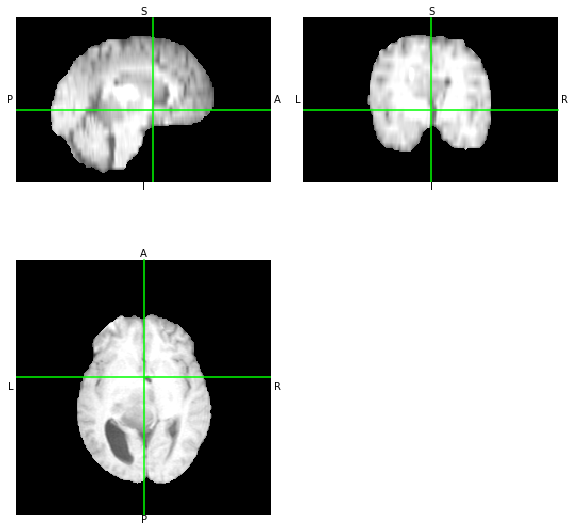

In [150]:
nib.load('/data/slow/PrepIMGs/TCGA-02-0011_T1.nii').orthoview()

In [142]:
t1_s

Unnamed: 0                                                9
Subject ID                                     TCGA-02-0047
Series Description                                    AX T1
File Location         /data/slow/BRATS_2021/train/00123/T1w
SET                                                 ONLY T1
Name: 9, dtype: object

In [137]:
f = dcm2nifti('/data/slow/BRATS_2021/train/00123/T1w', '.tmpdir')
f

220516-16:38:31,951 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:Found 23 DICOM file(s)
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-19.dcm'
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-8.dcm'
220516-16:38:31,953 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-9.dcm'
220516-16:38:31,953 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 

PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/T1w_T1w_0_5.nii.gz')

In [141]:
nib.load(f).get_fdata().min()

0.0

In [134]:
!ls {t1_s['File Location']}

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_T1w_0_5.nii.gz (256, 256, 23)>

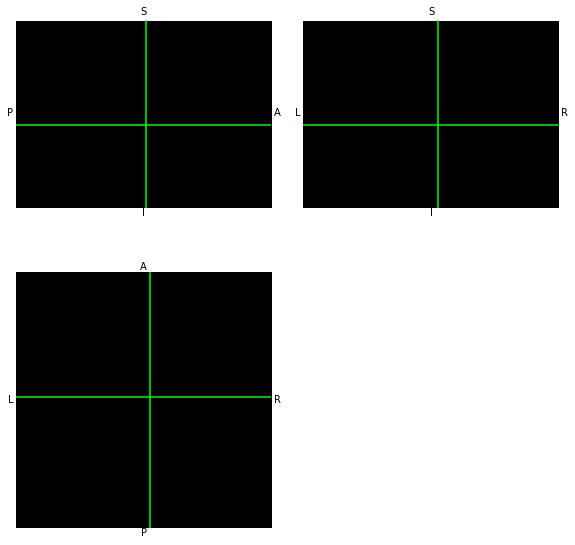

In [131]:
nib.load(t1_fpath).orthoview()

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5.nii.gz (240, 240, 155)>

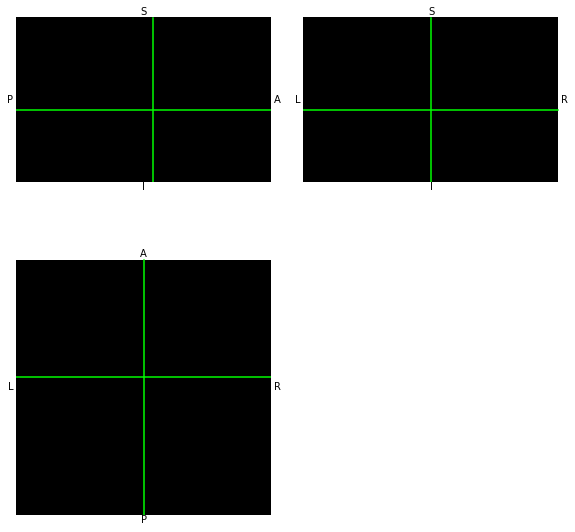

In [127]:
nib.load('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5.nii.gz').orthoview()

In [124]:
!ls {t1_s['File Location']}

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


In [119]:
t1_s

Unnamed: 0                                                9
Subject ID                                     TCGA-02-0047
Series Description                                    AX T1
File Location         /data/slow/BRATS_2021/train/00123/T1w
SET                                                 ONLY T1
Name: 9, dtype: object

In [120]:
!ls /data/slow/BRATS_2021/train/00123/T1w

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


In [121]:
!rm -rf .tmpdir/*

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5e.nii.gz (240, 240, 155)>

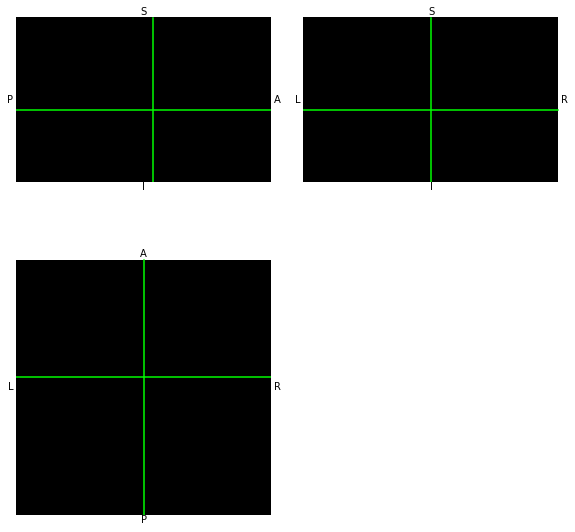

In [118]:
nib.load('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5e.nii.gz').orthoview()

In [113]:
Path(df_tcga_t1.iloc[8]['File Location']).exists()

False

In [108]:
!ls /data/slow/BRATS_2021/train/00123

FLAIR  T1w  T1wCE  T2w


# Make pred dir

In [57]:
df = pd.read_csv('/home/felipe-sassi/Data/DATASET_MASTER.csv')
df.head()

,Subject ID,Path,Filename,Age,Gender,Histology,Grade,TCGA Data\nCollection,IDH\nmutation\nStatus,1p/19q\nco-\ndeletion\nstatus,MGMT\npromoter\nstatus,Survival\n(months),Karnofsky\nperformance\nscores,Cross-\nvalidation\ngroup,Target
0,TCGA-02-0003,/data/slow/PrepIMGs/TCGA-02-0003_T2.nii,TCGA-02-0003_T2.nii,50.0,male,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,4.731106,100.0,2,0
1,TCGA-02-0006,/data/slow/PrepIMGs/TCGA-02-0006_T2.nii,TCGA-02-0006_T2.nii,56.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,18.333034,80.0,2,0
2,TCGA-02-0009,/data/slow/PrepIMGs/TCGA-02-0009_T2.nii,TCGA-02-0009_T2.nii,61.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,10.579278,80.0,2,0
3,TCGA-02-0011,/data/slow/PrepIMGs/TCGA-02-0011_T2.nii,TCGA-02-0011_T2.nii,18.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,20.698587,80.0,2,1
4,TCGA-02-0027,/data/slow/PrepIMGs/TCGA-02-0027_T2.nii,TCGA-02-0027_T2.nii,33.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,12.156313,100.0,2,0


In [58]:
s = df.iloc[0]
s

Subject ID                                                   TCGA-02-0003
Path                              /data/slow/PrepIMGs/TCGA-02-0003_T2.nii
Filename                                              TCGA-02-0003_T2.nii
Age                                                                    50
Gender                                                               male
Histology                                                    glioblastoma
Grade                                                                  G4
TCGA Data\nCollection                                            TCGA-GBM
IDH\nmutation\nStatus                                                  WT
1p/19q\nco-\ndeletion\nstatus                                   non-codel
MGMT\npromoter\nstatus                                       Unmethylated
Survival\n(months)                                                4.73111
Karnofsky\nperformance\nscores                                        100
Cross-\nvalidation\ngroup             

In [59]:
inference_dir = Path('/home/bruno-pacheco/brats-generalization/data/processed/IMGs')
inference_dir.exists()

True

In [62]:
for s in df.iloc:
    t2_fpath = Path(s['Path'])
    t1_fpath = Path(s['Path'].split('T2')[0] + 'T1.nii')
    
    assert t2_fpath.exists()
    assert t1_fpath.exists()
    
    t2_fpath_inference = inference_dir/(s['Subject ID'] + '_0001.nii.gz')
    t1_fpath_inference = inference_dir/(s['Subject ID'] + '_0000.nii.gz')
    
    nib.save(nib.load(t1_fpath), t1_fpath_inference)
    nib.save(nib.load(t2_fpath), t2_fpath_inference)

<OrthoSlicer3D: /data/slow/PrepIMGs/TCGA-02-0003_T1.nii (240, 240, 155)>

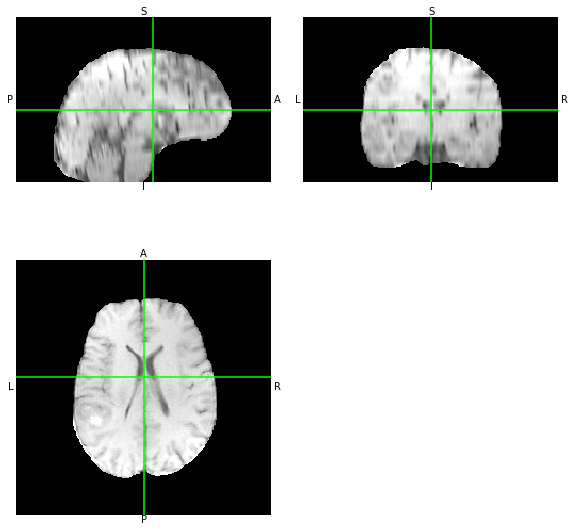

In [258]:
nib.load(t1_fpath).orthoview()

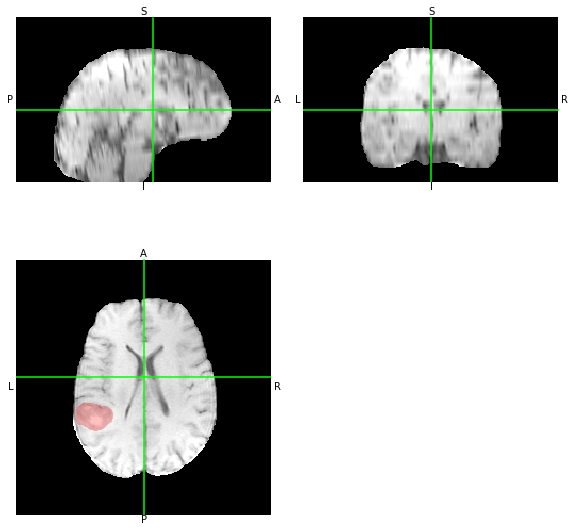

In [18]:
show_mri(t1_fpath, overlay='/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/TCGA-02-0003.nii.gz', overlay_label=2, pos=(0,0,0))

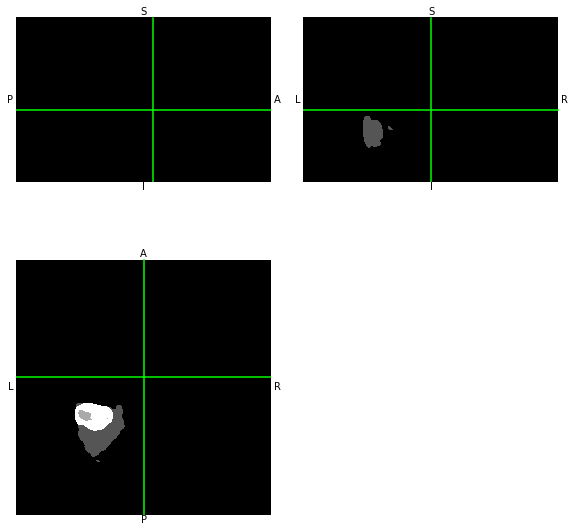

In [14]:
show_mri(, pos=(0,0,0))

In [274]:
show_mri(nib.load(t1_fpath),crop=(1.1,1.1,1.1))

TypeError: show_mri() got an unexpected keyword argument 'crop'

In [262]:
show_mri('/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/TCGA-02-0003.nii.gz', pos=(0,0,0))

IndexError: cannot do a non-empty take from an empty axes.

# Data check

In [21]:
yog = pd.read_csv('/home/bruno-pacheco/brats-generalization/yogananda.csv')
yog['ID'] = yog['Subject ID'].apply(lambda s: s.split('_')[0])
yog

,Subject ID,Age,Gender,Unnamed: 3,Histology,Grade,TCGA Data Collection,IDH\nmutation Status,1p/19q co- deletion\nstatus,MGMT\npromoter status,Survival (months),Karnofsky performance scores,Cross- validation group,ID
0,TCGA-02-0003,50.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,4.731106,100.0,2,TCGA-02-0003
1,TCGA-02-0006,56.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,18.333034,80.0,2,TCGA-02-0006
2,TCGA-02-0009,61.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,10.579278,80.0,2,TCGA-02-0009
3,TCGA-02-0011,18.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,20.698587,80.0,2,TCGA-02-0011
4,TCGA-02-0027,33.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,12.156313,100.0,2,TCGA-02-0027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,W39_19980919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W39
243,W5_19961211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W5
244,W54_20000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W54
245,W7_19961218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W7


In [26]:
(yog['Subject ID'].iloc[:224] == yog['ID'].iloc[:224]).all()

True

In [32]:
yog_tcga_ids = yog[yog['Subject ID'].str.startswith('TCGA')]['Subject ID']
yog_tcga_ids

0      TCGA-02-0003
1      TCGA-02-0006
2      TCGA-02-0009
3      TCGA-02-0011
4      TCGA-02-0027
           ...     
219    TCGA-HT-A5RB
220    TCGA-HT-A5RC
221    TCGA-HT-A616
222    TCGA-HT-A61A
223    TCGA-HT-A61B
Name: Subject ID, Length: 224, dtype: object

In [30]:
brats_tcga = pd.read_csv('/home/bruno-pacheco/brats-generalization/data/raw/MICCAI_BraTS2020_TrainingData/name_mapping.csv')['TCGA_TCIA_subject_ID']
brats_tcga.dropna()

157    TCGA-02-0006
158    TCGA-02-0009
159    TCGA-02-0011
160    TCGA-02-0027
161    TCGA-02-0033
           ...     
330    TCGA-HT-8018
331    TCGA-HT-8111
332    TCGA-HT-8114
333    TCGA-HT-8563
334    TCGA-HT-A61A
Name: TCGA_TCIA_subject_ID, Length: 167, dtype: object

In [37]:
len(set(yog_tcga_ids.values).intersection(set(brats_tcga.values)))

113

In [39]:
set(brats_tcga.values).difference(set(yog_tcga_ids.values))

{'TCGA-02-0054',
 'TCGA-02-0059',
 'TCGA-02-0068',
 'TCGA-02-0070',
 'TCGA-02-0085',
 'TCGA-02-0087',
 'TCGA-02-0106',
 'TCGA-02-0116',
 'TCGA-06-0130',
 'TCGA-06-0138',
 'TCGA-06-0139',
 'TCGA-06-0149',
 'TCGA-06-0154',
 'TCGA-06-0158',
 'TCGA-06-0162',
 'TCGA-06-0164',
 'TCGA-06-0176',
 'TCGA-06-0177',
 'TCGA-06-0179',
 'TCGA-06-0182',
 'TCGA-06-0184',
 'TCGA-06-0185',
 'TCGA-06-0187',
 'TCGA-06-0188',
 'TCGA-06-0190',
 'TCGA-06-0192',
 'TCGA-06-0238',
 'TCGA-06-0240',
 'TCGA-06-0644',
 'TCGA-06-0646',
 'TCGA-06-1084',
 'TCGA-06-1802',
 'TCGA-08-0355',
 'TCGA-08-0356',
 'TCGA-08-0359',
 'TCGA-08-0360',
 'TCGA-08-0385',
 'TCGA-08-0389',
 'TCGA-08-0390',
 'TCGA-08-0392',
 'TCGA-08-0509',
 'TCGA-08-0512',
 'TCGA-08-0520',
 'TCGA-08-0522',
 'TCGA-12-0616',
 'TCGA-12-0776',
 'TCGA-12-1094',
 'TCGA-12-1098',
 'TCGA-14-1825',
 'TCGA-19-0963',
 'TCGA-19-5951',
 'TCGA-19-5960',
 'TCGA-DU-6542',
 'TCGA-DU-7014',
 nan}

In [53]:
','.join(set(yog_tcga_ids.values).difference(set(brats_tcga.values)))

'TCGA-FG-A4MU,TCGA-76-4926,TCGA-CS-5390,TCGA-DU-6400,TCGA-HT-7860,TCGA-DU-A6S6,TCGA-FG-6688,TCGA-CS-6667,TCGA-FG-5963,TCGA-FG-A6J1,TCGA-HT-7468,TCGA-HT-A616,TCGA-HT-7469,TCGA-FG-7637,TCGA-HT-7478,TCGA-DU-6395,TCGA-06-0147,TCGA-HT-7855,TCGA-DU-6401,TCGA-DU-6407,TCGA-02-0060,TCGA-HT-7471,TCGA-06-1806,TCGA-76-4925,TCGA-HT-A5R5,TCGA-HT-7606,TCGA-14-0789,TCGA-HT-8105,TCGA-FG-A713,TCGA-27-1836,TCGA-DU-5871,TCGA-HT-7693,TCGA-CS-5395,TCGA-06-5412,TCGA-06-0129,TCGA-HT-7608,TCGA-HT-7902,TCGA-HT-8013,TCGA-DU-6408,TCGA-76-6286,TCGA-DU-A6S2,TCGA-HT-A5RB,TCGA-HT-8107,TCGA-12-1093,TCGA-76-6192,TCGA-HT-7692,TCGA-76-4928,TCGA-06-0133,TCGA-DU-5853,TCGA-HT-7874,TCGA-HT-7472,TCGA-HT-7616,TCGA-HT-7475,TCGA-HT-7856,TCGA-DU-A5TP,TCGA-FG-A87N,TCGA-HT-8564,TCGA-HT-7684,TCGA-CS-5394,TCGA-06-0143,TCGA-HT-8019,TCGA-76-4927,TCGA-27-1838,TCGA-HT-7481,TCGA-19-1791,TCGA-06-0148,TCGA-HT-8113,TCGA-76-4929,TCGA-HT-7476,TCGA-CS-6290,TCGA-HT-7695,TCGA-CS-4941,TCGA-FG-6690,TCGA-19-1390,TCGA-HT-8106,TCGA-CS-4943,TCGA-06-012

In [63]:
set(yog_tcga_ids.values).difference(set(brats_tcga.values))

{'TCGA-02-0003',
 'TCGA-02-0060',
 'TCGA-06-0128',
 'TCGA-06-0129',
 'TCGA-06-0133',
 'TCGA-06-0143',
 'TCGA-06-0147',
 'TCGA-06-0148',
 'TCGA-06-0881',
 'TCGA-06-1806',
 'TCGA-06-5412',
 'TCGA-12-1093',
 'TCGA-12-1602',
 'TCGA-14-0789',
 'TCGA-14-1829',
 'TCGA-19-1390',
 'TCGA-19-1791',
 'TCGA-19-2620',
 'TCGA-19-5953',
 'TCGA-27-1830',
 'TCGA-27-1835',
 'TCGA-27-1836',
 'TCGA-27-1838',
 'TCGA-76-4925',
 'TCGA-76-4926',
 'TCGA-76-4927',
 'TCGA-76-4928',
 'TCGA-76-4929',
 'TCGA-76-4931',
 'TCGA-76-6192',
 'TCGA-76-6286',
 'TCGA-CS-4938',
 'TCGA-CS-4941',
 'TCGA-CS-4943',
 'TCGA-CS-5390',
 'TCGA-CS-5394',
 'TCGA-CS-5395',
 'TCGA-CS-6290',
 'TCGA-CS-6667',
 'TCGA-DU-5849',
 'TCGA-DU-5852',
 'TCGA-DU-5853',
 'TCGA-DU-5871',
 'TCGA-DU-6395',
 'TCGA-DU-6397',
 'TCGA-DU-6399',
 'TCGA-DU-6400',
 'TCGA-DU-6401',
 'TCGA-DU-6405',
 'TCGA-DU-6407',
 'TCGA-DU-6408',
 'TCGA-DU-7013',
 'TCGA-DU-8158',
 'TCGA-DU-8165',
 'TCGA-DU-A5TP',
 'TCGA-DU-A6S2',
 'TCGA-DU-A6S3',
 'TCGA-DU-A6S6',
 'TCGA-FG-5963

In [37]:
len(set(yog_tcga_ids.values).intersection(set(brats_tcga.values)))

113

In [51]:
yog['is_prep'] = yog['ID'].apply(lambda s: len(list(Path("/data/slow/PrepIMGs").glob(f"{s}_*"))) > 0)
yog['is_prep'].value_counts()

True     237
False     10
Name: is_prep, dtype: int64

In [67]:
','.join(yog[~yog['is_prep']]['ID'].values)

'TCGA-02-0047,TCGA-76-4925,W34,W36,W38,W39,W5,W54,W7,W9'

In [68]:
yog[~yog['is_prep']]

,Subject ID,Age,Gender,Unnamed: 3,Histology,Grade,TCGA Data Collection,IDH\nmutation Status,1p/19q co- deletion\nstatus,MGMT\npromoter status,Survival (months),Karnofsky performance scores,Cross- validation group,ID,is_prep
9,TCGA-02-0047,78.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,14.718995,80.0,1,TCGA-02-0047,False
59,TCGA-76-4925,76.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,4.796815,100.0,2,TCGA-76-4925,False
239,W34_19980713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,2,W34,False
240,W36_19980714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,1,W36,False
241,W38_19980910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,2,W38,False
242,W39_19980919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W39,False
243,W5_19961211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W5,False
244,W54_20000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W54,False
245,W7_19961218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W7,False
246,W9_19970410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W9,False
